In [1]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from openbb import obb

In [2]:
obb.account.login(email = "your_email_here", password = "your_pw_here", remember_me = True)

In [9]:
data = obb.equity.price.historical("AMZN", start_date = "2020-01-01").to_df()

data.tail(5)

,open,high,low,close,volume,vwap,label,adj_close,unadjusted_volume,change,change_percent,change_over_time
date,,,,,,,,,,,,
2023-12-22,153.77,154.350,152.71,153.42,29514093,153.54,"December 22, 23",153.42,29480100.0,-0.35,-0.227610,-0.002276
2023-12-26,153.56,153.975,153.03,153.41,25067222,153.41,"December 26, 23",153.41,25067200.0,-0.15,-0.097682,-0.000977
2023-12-27,153.56,154.780,153.12,153.34,31344733,153.64,"December 27, 23",153.34,31434700.0,-0.22,-0.143270,-0.001433
2023-12-28,153.72,154.080,152.95,153.38,27057002,153.53,"December 28, 23",153.38,27057000.0,-0.34,-0.221180,-0.002212
2023-12-29,153.10,153.890,151.03,151.94,38181494,152.35,"December 29, 23",151.94,36399540.0,-1.16,-0.757670,-0.007577


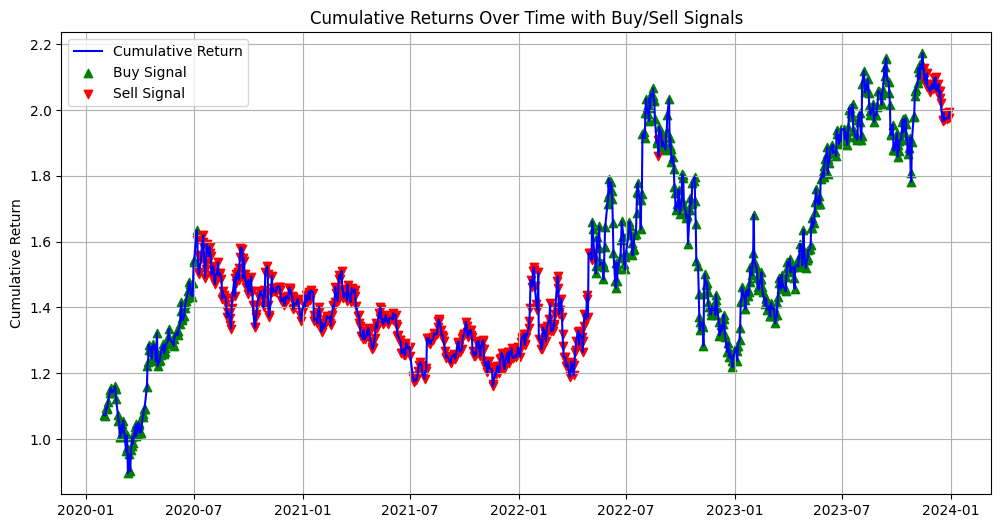

Final Portfolio Value: $19927.71


In [10]:
# Define parameters
initial_capital = 10000  # Initial capital
capital = initial_capital
position = 0  # Number of shares held
lookback_window = 20  # Number of past days used for feature engineering
perplexity = 30  # Perplexity parameter for t-SNE

# Feature engineering
data['SMA'] = data['close'].rolling(lookback_window).mean()
data['RSI'] = 100 - (100 / (
    1 + (data['close'].diff(1).apply(
        lambda x: 1 if x > 0 else 0
    ).rolling(lookback_window).sum() / lookback_window)))

# Drop rows with NaN values
data.dropna(inplace=True)

# Define X and y
X = data[['SMA', 'RSI']].values

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, perplexity=perplexity)
X_reduced = tsne.fit_transform(X)

# Define a simple trading rule based on t-SNE reduced features
data['Signal'] = np.where(X_reduced[:, 0] > np.median(X_reduced[:, 0]), 1, -1)

# Backtesting the strategy
data['Position'] = data['Signal'].shift(1)
data['Daily_Return'] = data['close'].pct_change() * data['Position']
data['Cumulative_Return'] = (1 + data['Daily_Return']).cumprod()
data['Portfolio_Value'] = initial_capital * data['Cumulative_Return']

# Plot cumulative returns with buy/sell markers
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Cumulative_Return'], label='Cumulative Return', color='b')
plt.scatter(
    data.index[data['Signal'] == 1],
    data['Cumulative_Return'][data['Signal'] == 1],
    marker='^',
    color='g',
    label='Buy Signal'
)
plt.scatter(
    data.index[data['Signal'] == -1],
    data['Cumulative_Return'][data['Signal'] == -1],
    marker='v',
    color='r',
    label='Sell Signal'
)
plt.title('Cumulative Returns Over Time with Buy/Sell Signals')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

# Print the final portfolio value
final_portfolio_value = data['Portfolio_Value'].iloc[-1]
print(f"Final Portfolio Value: ${final_portfolio_value:.2f}")
